# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (morfemy). W przeciwieństwie do podejść lingwistycznych, wymagających reguł tworzenia morfemów, BPE wyznacza je automatycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków które występują obok siebie.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20) razy
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10) razy
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technike BPE na tych słowach.

Zaimplementuj algorytm BPE wykonujący `number_of_iterations` iteracji (łączeń symboli).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [1]:
import pandas as pd
import numpy as np

brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=0, names=['cluster', 'word', 'count'])


def find_pairs(symbols, multiplier):
    pairs_dct = dict()

    for i in range(len(symbols) - 1):
        key = f"{symbols[i]},{symbols[i + 1]}"
        pairs_dct[key] = pairs_dct.get(key, 0) + multiplier

    return pairs_dct


def preform_bpe(brown_df, number_of_iterations):
    """
    Funckcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    brown_df['word'] = brown_df['word'].astype(str)
    brown_df['word'] = brown_df['word'].apply(lambda x: str(list(x))[1:-1].replace("'", "").replace(" ", "") + ",END")

    pairs_global_dct = dict()
    for index, row in brown_df.iterrows():
        word_pairs_dct = find_pairs(row['word'].split(','), row['count'])
        for k in word_pairs_dct.keys():
            pairs_global_dct[k] = pairs_global_dct.get(k, 0) + word_pairs_dct[k]

    for _ in range(number_of_iterations):
        top_pair = max(pairs_global_dct, key=pairs_global_dct.get)
        top_pair_merged = top_pair.replace(",", "")
        # print("Top pair:", top_pair)
        influenced_df = brown_df[brown_df['word'].str.contains(top_pair)]
        brown_df['word'] = brown_df['word'].replace(top_pair, top_pair_merged, regex=True)

        for index, row in influenced_df.iterrows():
            symbols = row['word'].split(',')
            word_pairs_dct = find_pairs(symbols, row['count'])
            for k in word_pairs_dct.keys():
                pairs_global_dct[k] = pairs_global_dct.get(k, 0) - word_pairs_dct[k]

            # influenced_df.loc[index,'word'] = influenced_df.loc[index,'word'].replace(top_pair, top_pair_merged)

            symbols = brown_df.loc[index, 'word'].split(',')
            word_pairs_dct = find_pairs(symbols, row['count'])
            for k in word_pairs_dct.keys():
                pairs_global_dct[k] = pairs_global_dct.get(k, 0) + word_pairs_dct[k]

    return brown_df["word"].apply(lambda x: x.replace(",", " ")).values.tolist()

Test implementacji:

In [2]:
from nose.tools import assert_list_equal

data = {'cluster': range(2), 'word': ['ala', 'mama'], 'count': [5, 10]}
df = pd.DataFrame(data, columns=['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [3]:
preform_bpe(brown_df, 50)

['\\..END',
 '...END',
 't o d a...END',
 '....END',
 '# y ou e...END',
 'i f in a...END',
 '..END',
 '...END',
 'i....END',
 '..END',
 'w h a t ....END',
 'i i i i i i i...END',
 '\\ue6d.END',
 'i k i...END',
 'l o...END',
 'i a c t u a...END',
 'w a....END',
 '# a s l on g a....END',
 'd o...END',
 '\\u200e \\u200..END',
 '..END',
 '.END',
 '# l o l a t g i r l ....END',
 '# r t i ....END',
 'i...END',
 '..END',
 '..END',
 'w ....END',
 'w h a...END',
 '..END',
 '..END',
 '# y ou r f a c e m a k e...END',
 'i i i i i...END',
 '..END',
 'i i i i...END',
 'i al re...END',
 '..END',
 '# y ou m a....END',
 '..END',
 '..END',
 '# u r b o y f r i e n d e...END',
 'w ....END',
 '.END',
 'd on "" ....END',
 'w h o....END',
 '....END',
 'w h a d ....END',
 'i o...END',
 'i ....END',
 'i al ....END',
 'i i...END',
 'd o....END',
 '..END',
 'd "...END',
 '.END',
 '# u e...END',
 'in e...END',
 'i..END',
 'i...END',
 '...END',
 'i s....END',
 'w h a....END',
 'd "....END',
 'i re a...END',
 'd o

- Jakie angielskie słowo jako pierwsze dostało swój własny token?

Najszybciej swój token dostało słowo "in", jeżeli jednak nie liczymy go jako słowa będzie to następne w kolejce "MENTION"

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji (problem OOV, odnieś się do  k-gramów i n-gramów)?

YOUR ANSWER HERE

Wróć do implementacji i zakomentuj wypisywanie (funkcje print) informacji z funkcji `preform_bpe`.

# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [4]:
from helpers import DataSet

training_set = DataSet(['tweets.txt'])

Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [5]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
negative


Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz przykłady uczące na cechy rośnie do bardzo dużych rozmiarów nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator (najlepiej taki, który się szybko liczy) na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.feature_extraction import FeatureHasher

token_counts = []
for row in training_set.tweets:
    token_counts.append(Counter(row.tokens))

y = np.array([y.clazz for y in training_set.tweets])
X = FeatureHasher(n_features=10).transform(token_counts).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.48224195338512765


- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

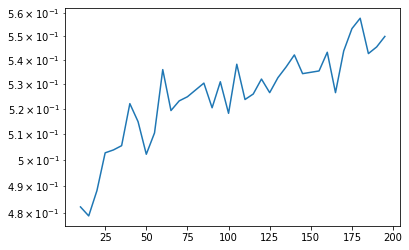

In [7]:
import matplotlib.pyplot as plt

scores = []
n_features = range(10, 200, 5)

for i in n_features:
    X = get_n_feature_data(token_counts, i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(list(n_features), scores)
plt.yscale("log")

 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

YOUR ANSWER HERE

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [8]:
from pandas import DataFrame

# tweets_df = DataFrame(data=token_counts,columns=['word','count'])
c = Counter()
for row in training_set.tweets:
    c.update(row.tokens)

tweets_df = DataFrame.from_dict({'word':c.keys(),'count':c.values()})
print(tweets_df)

X = preform_bpe(tweets_df,10)
print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

                         word  count
0                        dear     10
1                  @microsoft     95
2                         the   4352
3                  newooffice      1
4                         for   1194
...                       ...    ...
16099             @racalto_sk      1
16100                colombia      1
16101                    peru      1
16102                  mendez      1
16103  http://t.co/mua1e0zrdc      1

[16104 rows x 2 columns]
['d e a .END', '@ m i c r o s o f tEND', 'th eEND', 'n e w o o f f i c eEND', 'f o .END', 'm a .END', 'i sEND', 'g r e a tEND', 'a n dEND', 'a l .END', '.END', 'b u tEND', 'n .END', 'l y n .END', 'u p d a t eEND', '.END', 'c "" m o nEND', '.END', 'h o .END', 'a b o u tEND', 'y o .END', 'm a k eEND', '.END', 's y s t e .END', 'th a tEND', 'd o e sEND', 'n "" tEND', 'e a tEND', 'm yEND', 'f r i g g inEND', 'd i s c sEND', 'th i sEND', '2 n dEND', 't i m eEND', 'h a sEND', 'h a p p e n e dEND', '.END', 'a .END', 's .END', 's i 

ValueError: Found input variables with inconsistent numbers of samples: [16104, 5459]

- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

YOUR ANSWER HERE